# Boston housing data

In [1]:
%connect_info

https://mljar.com/blog/feature-importance-xgboost/

## Load libraries

In [2]:
import itertools

import numpy as np
import pandas as pd
import seaborn as sns

from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

## Get data

Load the boston data

In [3]:
boston = load_boston()

In [4]:
boston.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [5]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [6]:
df = pd.DataFrame(boston.data, columns=boston.feature_names)

In [7]:
df['target'] = boston.target

In [8]:
df['CHAS'] = df.CHAS.astype('boolean')

## Summarize data

In [9]:
df.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'target'],
      dtype='object')

In [10]:
df.dtypes

CRIM       float64
ZN         float64
INDUS      float64
CHAS       boolean
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD        float64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
target     float64
dtype: object

In [11]:
df.describe()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


## Descriptive analysis

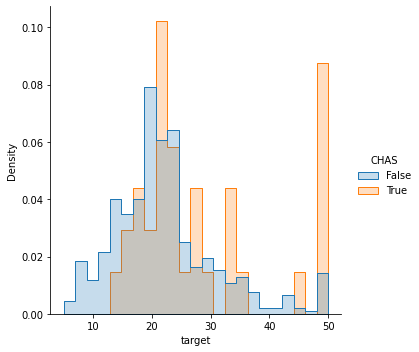

In [12]:
sns.displot(x='target', hue='CHAS', stat='density',
            common_norm=False, data=df, element='step')

In [13]:
features = set(df.columns) - set(['CHAS'])

Display correlation table

In [14]:
corr = df[features].corr()

Display features with high correlation with the target

In [15]:
corr[['target']].sort_values('target', ascending=False)

,target
target,1.000000
RM,0.695360
ZN,0.360445
B,0.333461
DIS,0.249929
AGE,-0.376955
RAD,-0.381626
CRIM,-0.388305
NOX,-0.427321
TAX,-0.468536


Correlation table

In [16]:
features = set(df.columns) - set(['CHAS', 'target'])
corr = df[features].corr()
corr

,NOX,LSTAT,RAD,ZN,B,RM,CRIM,TAX,AGE,PTRATIO,DIS,INDUS
NOX,1.000000,0.590879,0.611441,-0.516604,-0.380051,-0.302188,0.420972,0.668023,0.731470,0.188933,-0.769230,0.763651
LSTAT,0.590879,1.000000,0.488676,-0.412995,-0.366087,-0.613808,0.455621,0.543993,0.602339,0.374044,-0.496996,0.603800
RAD,0.611441,0.488676,1.000000,-0.311948,-0.444413,-0.209847,0.625505,0.910228,0.456022,0.464741,-0.494588,0.595129
ZN,-0.516604,-0.412995,-0.311948,1.000000,0.175520,0.311991,-0.200469,-0.314563,-0.569537,-0.391679,0.664408,-0.533828
B,-0.380051,-0.366087,-0.444413,0.175520,1.000000,0.128069,-0.385064,-0.441808,-0.273534,-0.177383,0.291512,-0.356977
RM,-0.302188,-0.613808,-0.209847,0.311991,0.128069,1.000000,-0.219247,-0.292048,-0.240265,-0.355501,0.205246,-0.391676
CRIM,0.420972,0.455621,0.625505,-0.200469,-0.385064,-0.219247,1.000000,0.582764,0.352734,0.289946,-0.379670,0.406583
TAX,0.668023,0.543993,0.910228,-0.314563,-0.441808,-0.292048,0.582764,1.000000,0.506456,0.460853,-0.534432,0.720760
AGE,0.731470,0.602339,0.456022,-0.569537,-0.273534,-0.240265,0.352734,0.506456,1.000000,0.261515,-0.747881,0.644779
PTRATIO,0.188933,0.374044,0.464741,-0.391679,-0.177383,-0.355501,0.289946,0.460853,0.261515,1.000000,-0.232471,0.383248


<AxesSubplot:>

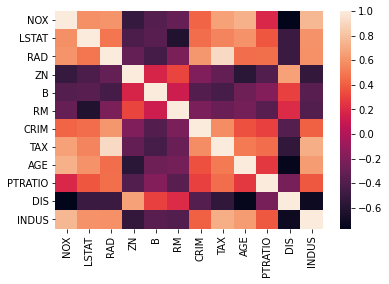

In [17]:
sns.heatmap(corr)

Get high correlation features

In [18]:
threshold = 0.9
high_corr_pairs = []
for col in corr:
    abs_corr = corr[col].abs()
    high_corr = corr[col][(abs_corr > threshold) & (abs_corr < 1)]
    if len(high_corr.index.values) > 0:
        for key in high_corr.index.values:
            high_corr_pairs.append(tuple(sorted((col, key))))

In [19]:
set(high_corr_pairs)

{('RAD', 'TAX')}

## Plot of numeric variable with target

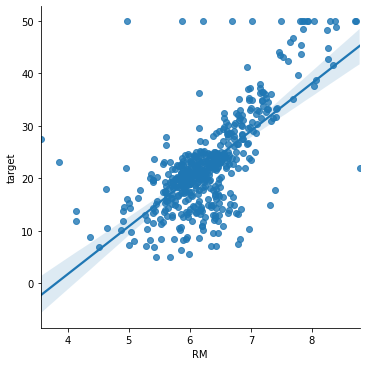

In [20]:
sns.lmplot(data=df, x='RM', y='target')

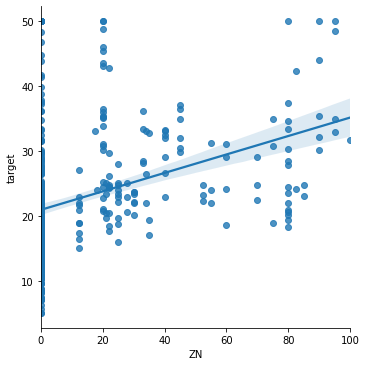

In [21]:
sns.lmplot(data=df, x='ZN', y='target')

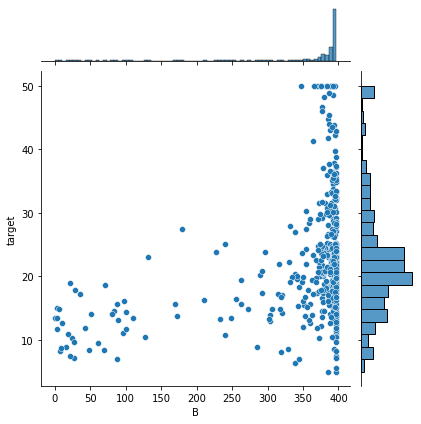

In [22]:
sns.jointplot(data=df, x='B', y='target')

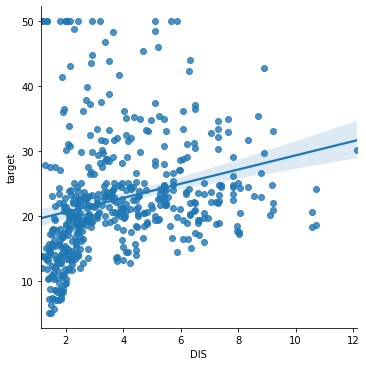

In [23]:
sns.lmplot(data=df, x='DIS', y='target')

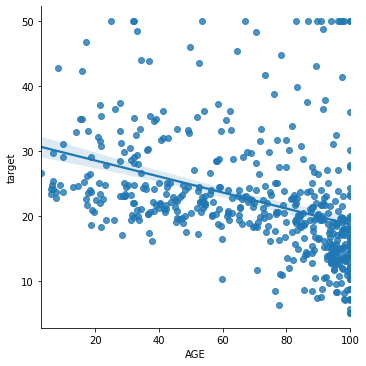

In [24]:
sns.lmplot(data=df, x='AGE', y='target')

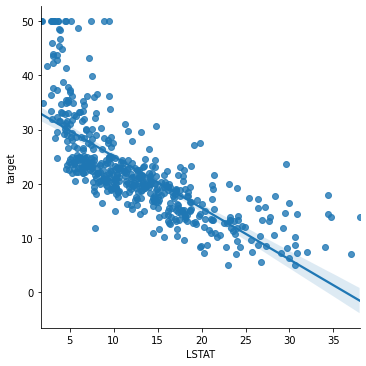

In [25]:
sns.lmplot(data=df, x='LSTAT', y='target')

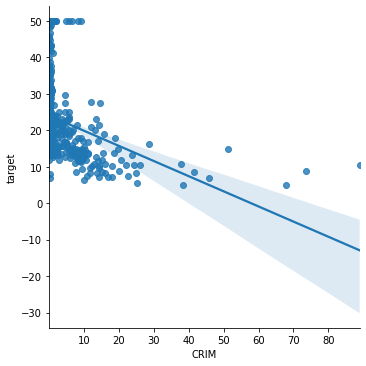

In [46]:
sns.lmplot(data=df, x='CRIM', y='target')

## Gradient boosting model

Setup the data for the model

In [26]:
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

Train the model

In [27]:
xgb = XGBRegressor(n_estimators=100, importance_type='gain')
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## Feature importance

In [28]:
importance = pd.Series(
    data=xgb.feature_importances_,
    index=boston.feature_names
).to_frame(name='importance').reset_index().rename(
    columns={'index': 'feature'})

<AxesSubplot:xlabel='importance', ylabel='feature'>

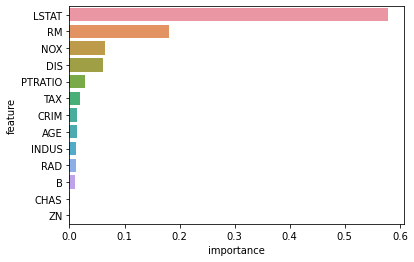

In [29]:
sns.barplot(
    x='importance', y='feature', data=importance,
    order=importance.sort_values(
        'importance', ascending=False).feature)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

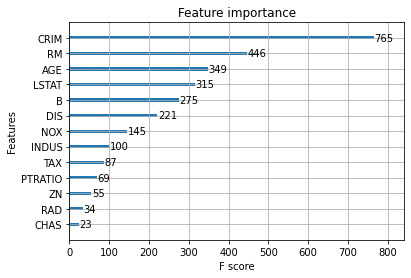

In [30]:
plot_importance(xgb)

In [31]:
perm_importance_dict = permutation_importance(xgb, X_train, y_train)

In [32]:
perm_importance = pd.Series(
    data=perm_importance_dict['importances_mean'],
    index=boston.feature_names
).to_frame(name='importance').reset_index().rename(
    columns={'index': 'feature'})

<AxesSubplot:xlabel='importance', ylabel='feature'>

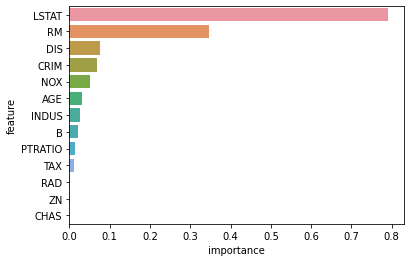

In [33]:
sns.barplot(
    x='importance', y='feature', data=perm_importance,
    order=perm_importance.sort_values(
        'importance', ascending=False).feature)

In [34]:
perm_importance_dict['importances_mean']

array([6.84621665e-02, 2.10614951e-04, 2.66964613e-02, 8.34207045e-05,
       5.12989401e-02, 3.46044485e-01, 3.21113887e-02, 7.57469382e-02,
       1.04753389e-03, 1.13953974e-02, 1.25676195e-02, 2.01489038e-02,
       7.91682640e-01])

In [35]:
y_predict = xgb.predict(X_test)

In [36]:
r2_score(y_test, y_predict)

0.8563261320300065

## Intepretable models

In [55]:
from interpret import show
from interpret.data import Marginal
marginal = Marginal().explain_data(X_train, y_train, name = 'Train Data')
show(marginal)

<!-- http://127.0.0.1:7001/140173304937104/ -->

In [44]:
from interpret.glassbox import ExplainableBoostingRegressor

ebm = ExplainableBoostingRegressor(random_state=42)
ebm.fit(X_train, y_train)

ExplainableBoostingRegressor(feature_names=['CRIM', 'ZN', 'INDUS', 'CHAS',
                                            'NOX', 'RM', 'AGE', 'DIS', 'RAD',
                                            'TAX', 'PTRATIO', 'B', 'LSTAT'],
                             feature_types=['continuous', 'continuous',
                                            'continuous', 'categorical',
                                            'continuous', 'continuous',
                                            'continuous', 'continuous',
                                            'continuous', 'continuous',
                                            'continuous', 'continuous',
                                            'continuous'])

In [45]:
ebm_global = ebm.explain_global(name='EBM')
show(ebm_global)

<!-- http://127.0.0.1:7001/140171061921872/ -->

In [49]:
from interpret.perf import RegressionPerf

In [52]:
ebm_perf = RegressionPerf(ebm.predict).explain_perf(
    X_test, y_test, name='EBM')

In [53]:
show(ebm_perf)

<!-- http://127.0.0.1:7001/140171212851808/ -->